Rupesh Bharambe (AI3107)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import math

In [4]:
# Load training and testing data
train_df = pd.read_csv('DailyDelhiClimateTrain.csv')
test_df = pd.read_csv('DailyDelhiClimateTest.csv')

In [5]:
# Set date as index
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
train_df.set_index('date', inplace=True)
test_df.set_index('date', inplace=True)


In [6]:
# Select features and target
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

In [7]:
# Function to create time series dataset for LSTM
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back][0])  # Predicting meantemp
    return np.array(X), np.array(y)


In [8]:
# Hyperparameter: Look back days
look_back = 3

# Prepare data
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)


In [9]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[2]))

In [10]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, len(features))))
model.add(Dense(1))  # Predicting meantemp
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\rupes\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Train model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2172
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 12/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038
Epoch 13/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 14/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 15/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 16/50
92/92 ━

In [12]:
# Predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [16]:
# Invert scaling
def inverse_transform(predicted, X_data):
    # X_data is 3D: (samples, look_back, features), we use the last timestep
    last_features = X_data[:, -1, 1:]  # other 3 features
    combined = np.concatenate([predicted, last_features], axis=1)  # shape (N, 4)
    return scaler.inverse_transform(combined)[:, 0]  # return only the inverse of meantemp

train_pred_inv = inverse_transform(train_predict, X_train)
y_train_inv = inverse_transform(y_train.reshape(-1, 1), X_train)

test_pred_inv = inverse_transform(test_predict, X_test)
y_test_inv = inverse_transform(y_test.reshape(-1, 1), X_test)

In [17]:
# Calculate RMSE
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

Train RMSE: 1.65
Test RMSE: 1.78


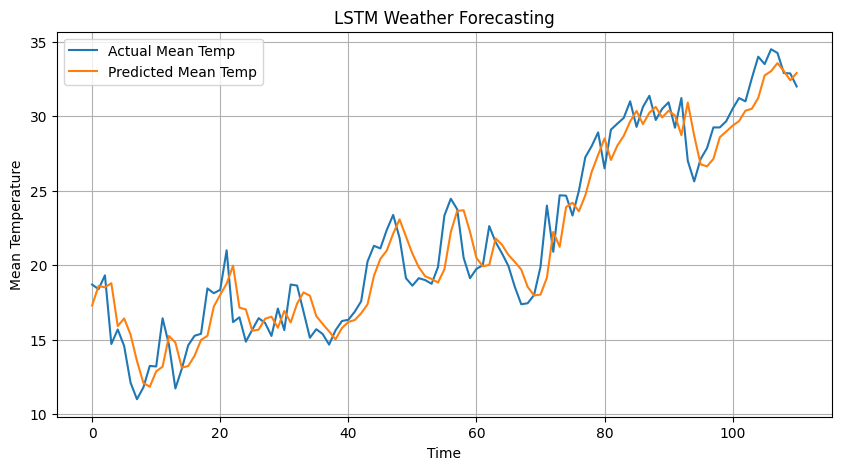

In [18]:
# Plot results
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Mean Temp')
plt.plot(test_pred_inv, label='Predicted Mean Temp')
plt.title('LSTM Weather Forecasting')
plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid(True)
plt.show()